# Goal:
- Building an LLM agent with tool nodes, chaining it up, adding routing logic and memory

# Simple chaining example with Langgraph
## Components
- Using chat messages in graph
- Using chat models
- Binding tools to our LLM
- Executing tool calls in our graph

# Messages
- HumanMessage, AIMessage, SystemMessage, ToolMessage
## Messages can be supplied with a few things:
- content: Content of the message
- name: Optionally, who's creating the message
- response_metadata: optionally, a dict of metadata that is often specific to each model provider

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content = f"So you said you were researching ocen mammals?", name= "Model")]
messages.extend([HumanMessage(content=f"Yes, that's right.", name = "abc")])
messages.extend([AIMessage(content=f"Great, what would you like to learn about?", name="Model")])
messages.extend([HumanMessage(content=f"I want to learn about the best place to see Orcas in the USA.", name="abc")])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocen mammals?
================================ Human Message =================================
Name: abc

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about?
================================ Human Message =================================
Name: abc

I want to learn about the best place to see Orcas in the USA.


# Chat Models
- Can use a sequence of messages as input and support message roles


In [2]:
# setting up env variables for chat models
import os, getpass
def _set_env(var:str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"{var}: ")
_set_env('OPENAI_API_KEY')

In [3]:
# Now we load the messages into chatmodel
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o')
result = llm.invoke(messages)


In [4]:
result, result.response_metadata 

(AIMessage(content='One of the best places to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington state. This area is renowned for its resident orca pods and offers various whale-watching tours that provide opportunities to see these majestic creatures in their natural habitat. The peak time for orca sightings in the San Juan Islands typically runs from late spring to early fall, with the highest chances of observing them in the summer months.\n\nOther notable locations for orca watching in the U.S. include:\n\n1. Olympic Peninsula, Washington: The waters near Port Angeles and around the Strait of Juan de Fuca are also excellent for spotting orcas.\n\n2. Monterey Bay, California: While this area is more famous for other marine life, orcas can occasionally be sighted here, especially during feeding season.\n\nEach location offers a unique experience, and local tour operators often provide educational insights into orca behavior

# Using tools

In [5]:
def multiply(a:int, b:int)->int:
    """Multiply two numbers

    Args:
        a (int): first number
        b (int): second number

    Returns: 
        int: Product of 2 numbers
    """
    return a * b

In [6]:
llm_with_tools = llm.bind_tools([multiply])

In [7]:
tool_call  = llm_with_tools.invoke([HumanMessage(content="What is 3 multiplied by 100?", name="abc")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UWtkUJa4fikjMMS6OtDtKI6D', 'function': {'arguments': '{"a":3,"b":100}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C7X257jf2so38WIFjNRPid9bVjsVJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bf4af126-ff36-49c9-8590-ada589b5a25a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 100}, 'id': 'call_UWtkUJa4fikjMMS6OtDtKI6D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache

# Using messages as graph state
## Need to use reducers to avoid rewriting the message state. We need to store conversation history and reducers allow us to do that
- Reducers allow us to specify hwo state updates are performed
- If no reducer key is specified, it's assumed that all updates to that key should override
- add_messages reducer allows us to append messages
- We annotate our key by using Annotated with a reducer function as metadata
- Langgraph has a MessagesState by default which does this for you

In [8]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
class MessagesState(BaseModel):
    messages:Annotated[list[AnyMessage], add_messages] = Field(...,description="List of messages of any kind")

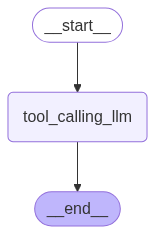

({'messages': [HumanMessage(content='I wanna learn about spaceX!', additional_kwargs={}, response_metadata={}, id='0da60960-b85e-4da3-9029-9d1de3b7618f'),
   AIMessage(content="SpaceX, or Space Exploration Technologies Corp., is a private aerospace manufacturer and space transportation company founded by Elon Musk in 2002. Here are some key points about SpaceX:\n\n1. **Mission**: SpaceX was established with the goal of reducing space transportation costs and enabling the colonization of Mars.\n\n2. **Achievements**:\n   - It was the first privately funded company to send a spacecraft to the International Space Station (ISS), which it did with its Dragon spacecraft in 2012.\n   - It was also the first private company to send astronauts to the ISS (in 2020), using the Crew Dragon spacecraft as part of NASA's Commercial Crew Program.\n\n3. **Rockets and Vehicles**:\n   - **Falcon 1**: The first privately developed liquid-fueled rocket to reach orbit.\n   - **Falcon 9**: A reusable rocket 

In [10]:
# Building a graph with messagesstate 
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# define nodes
def tool_calling_llm(state:MessagesState):
    return {"messages":[llm_with_tools.invoke(state.model_dump()['messages'])]}

# build graph
builder = StateGraph(MessagesState)
builder.add_node('tool_calling_llm', tool_calling_llm)

# add edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_edge('tool_calling_llm', END)

# compile graph
graph = builder.compile()

# display graph
display(Image(graph.get_graph().draw_mermaid_png()))

# invoke graph
graph.invoke({'messages':HumanMessage(content='I wanna learn about spaceX!')}), graph.invoke({'messages': HumanMessage(content='Help me I am stuck in a math problem. I dont know how to multiply 5 with 2!')})


# Router
- Asking LLM to choose between two or more possible paths to execute a user query
- simple example: Asking an LLM to choose between a.) returning a tool call and b.) returning a natural language response 

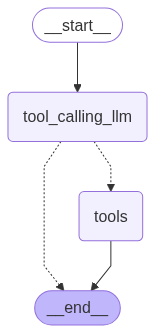

In [11]:
# rebuilding graphs but now our agent can actually use tools because we add a new node called ToolNode
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state:MessagesState):
    return {"messages": [llm_with_tools.invoke(state.model_dump()["messages"])]}

# build the graph
builder = StateGraph(MessagesState)

# add nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode([multiply]))

# add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge('tools', END)

# compile graph
graph = builder.compile()

# View graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from langchain_core.messages import HumanMessage
messages = [
            #HumanMessage(content="Help me multiply 5 and -20"),
            HumanMessage(content='Tell me something about space X'),
            #HumanMessage(content='Whats 2 x44?')
            ]
messages = graph.invoke({'messages':messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me something about space X
================================ Human Message =================================

Whats 2 x44?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vOCgPPdYw7MWk9MQoOUwvLnB)
 Call ID: call_vOCgPPdYw7MWk9MQoOUwvLnB
  Args:
    a: 2
    b: 44
================================= Tool Message =================================
Name: multiply

88


# Agent using a ReAct architecture
- Passing the messages back to the model
- Agent can react on this and decide if it wants to:
    - call another tool
    - respond directly
## ReAct architecture
- act: let the model call specific tools
- observe: pass the tool output back to the model
- reason: let the model reason about the tool output to decide what to do next(e.g calling another tool or respond directly)

In [20]:
# load env vars
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
# building tools for agent to use
from typing import Union
def multiply(a:int, b:int) -> int:
    """
    Multiply two numbers together
    """
    return a * b

def add(a:int, b:int) -> int:
    """
    Add two numbers together
    """
    return a + b

def subtract(a:int, b:int) -> int:
    """
    Subtract two numbers together
    """
    return a - b

def divide(a:int, b:int) -> Union[float, None]:
    """
    Divide two numbers together
    """
    return a / b if b != 0 else None

In [22]:
tools = [add, subtract, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [23]:
from langchain_core.messages import HumanMessage, SystemMessage

system_message = SystemMessage(content="You are a helpful assistnat tasked with performing arithmetic on a set of inputs.")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([system_message] + state.model_dump()['messages'])]}

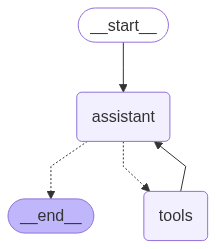

In [24]:
# Building the graph with ReAct framework
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

# builder
builder = StateGraph(MessagesState)
# add nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))
# add edges
builder.add_edge(START,'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition
)
builder.add_edge('tools', 'assistant')
#compile graph
react_graph = builder.compile()

# display graph
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [29]:
messages = [HumanMessage(content="Add 2 and 5, multiply the result by (3 divided by 2)")]
messages = react_graph.invoke({'messages':messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 5, multiply the result by (3 divided by 2)
================================== Ai Message ==================================
Tool Calls:
  add (call_TbPHK5AjgUH9xsdmXlglGlkS)
 Call ID: call_TbPHK5AjgUH9xsdmXlglGlkS
  Args:
    a: 2
    b: 5
  divide (call_78fblENLC7eK8CjEkPcS8gfk)
 Call ID: call_78fblENLC7eK8CjEkPcS8gfk
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: divide

1.5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oJeWIVDIvv4gU3e4DT67ipIy)
 Call ID: call_oJeWIVDIvv4gU3e4DT67ipIy
  Args:
    a: 7
    b: 1.5
================================= Tool Message =================================
Name: multiply

Error: 1 validation error for multiply
b
  Input should be a valid 

# Memory
- We want to add memory to our agent. Just adding reducers to our State isn't enough. State is limited to a particular graph invocation
- We can achieve this by adding persistence
- Langchain has checkpointers to address this
- Easiest checkpointer: MemorySaver (invalue KV store) to save graph state at each state
- just compile the graph with checkpointer set to an instance of MemorySaver()
- when using memory, we will need to specify a thread_id. Threads store our collection of graph states
- to add threads, just supply a thread id along with messages when invoking the graph
    - config = {"configurable": {"thread_id" :"1"}}
    - react_graph_w_memory.invoke({"messages":messages}, config)

In [34]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_w_memory = builder.compile(checkpointer=memory)

In [35]:
config = {"configurable": {"thread_id" :"1"}}
#input messages
messages = [HumanMessage(content="Add 4 and 6")]
# invoke graph
messages = react_graph_w_memory.invoke({"messages":messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 6
================================== Ai Message ==================================
Tool Calls:
  add (call_VXBv1dXHny4zLLtsdvhMRI62)
 Call ID: call_VXBv1dXHny4zLLtsdvhMRI62
  Args:
    a: 4
    b: 6
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The sum of 4 and 6 is 10.


In [36]:
messages = [HumanMessage(content="Multiply that by 2")]
react_graph_w_memory.invoke({"messages":messages}, config)
messages = react_graph_w_memory.invoke({"messages":messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 6
================================== Ai Message ==================================
Tool Calls:
  add (call_VXBv1dXHny4zLLtsdvhMRI62)
 Call ID: call_VXBv1dXHny4zLLtsdvhMRI62
  Args:
    a: 4
    b: 6
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The sum of 4 and 6 is 10.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YjsJgETw7S0YUleBw9GaXSV5)
 Call ID: call_YjsJgETw7S0YUleBw9GaXSV5
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

Multiplying 10 by 2 